<a href="https://colab.research.google.com/github/YunSeoHwan/My-own-study-repository/blob/main/%5BBaseline%5D_Parquet_%EB%B3%80%ED%99%98%EA%B3%BC_Random_Forest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
import lightgbm as lgb
import torch

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
# from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# csv to parquet
메모리에 효율적인 데이터 유형을 사용하여 용량을 줄이고 빠른 작업이 가능합니다

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
csv_to_parquet('/content/drive/MyDrive/dacon_data/Airline/train.csv', 'train')
csv_to_parquet('/content/drive/MyDrive/dacon_data/Airline/test.csv', 'test')

FileNotFoundError: ignored

# Data Load and EDA

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/dacon_data/Airline/train.parquet')
test = pd.read_parquet('/content/drive/MyDrive/dacon_data/Airline/test.parquet')
sample_submission = pd.read_csv('/content/drive/MyDrive/dacon_data/Airline/sample_submission.csv', index_col = 0)

In [ ]:
train.head(5)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [ ]:
(train['Delay'] == 'None').value_counts()

False    1000000
Name: Delay, dtype: int64

In [ ]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [ ]:
# 수치형 describe
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [ ]:
# categorical describe
train.describe(include='all')

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
count,1000000,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000,1000000.000000,890985,1000000,1000000.000000,890921,1000000.000000,891080,891010,891003.000000,1000000,255001
unique,1000000,NaN,NaN,NaN,NaN,NaN,NaN,374,NaN,52,375,NaN,52,NaN,28,11,NaN,6430,2
top,TRAIN_000000,NaN,NaN,NaN,NaN,NaN,NaN,ORD,NaN,California,ORD,NaN,California,NaN,Southwest Airlines Co.,UA,NaN,N483HA,Not_Delayed
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,50436,NaN,103482,50171,NaN,104347,NaN,182113,206211,NaN,530,210001
mean,NaN,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,NaN,12696.278484,NaN,NaN,12701.813986,NaN,784.078499,NaN,NaN,19997.388093,NaN,NaN
std,NaN,3.462506,8.763515,489.814011,520.803494,0.0,0.0,NaN,1514.938441,NaN,NaN,1515.213044,NaN,590.790469,NaN,NaN,404.268639,NaN,NaN
min,NaN,1.000000,1.000000,1.000000,1.000000,0.0,0.0,NaN,10135.000000,NaN,NaN,10135.000000,NaN,16.000000,NaN,NaN,19393.000000,NaN,NaN
25%,NaN,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,NaN,11292.000000,NaN,NaN,11292.000000,NaN,350.000000,NaN,NaN,19790.000000,NaN,NaN
50%,NaN,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,NaN,12889.000000,NaN,NaN,12889.000000,NaN,623.000000,NaN,NaN,19977.000000,NaN,NaN
75%,NaN,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,NaN,14057.000000,NaN,NaN,14057.000000,NaN,1020.000000,NaN,NaN,20378.000000,NaN,NaN


In [ ]:
# ID
# Cancelled, Diverted --> DROP!! (train/test all 0 )
# Distance 중요 변수 일 듯

################################################################################################

# Month, Day_of_Month --> date 관련 변수로 전처리 필요
# Estimated_Departure_Time, Estimated_Arrival_Time --> time 관련 변수로 전처리 필요! && 결측치 존재

################################################################################################

# Origin_Airport = Origin_Airport_ID
# Destination_Airport = Destination_Airport_ID

# Origin_State, Destination_State -->  결측치 존재 BUT!!! Airport 정보로 결측치 일부 채울 수 있음.

################################################################################################

# 얘넨 결측치 존재
# Carrier_Code != Carrier_ID 
# 항공사 명마다 대응하는 IATA code가 있음

################################################################################################

# Tail_Number 필요할까? (class 개수만 6430개)

In [ ]:
train.head(10)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,600.0,1900.0,252,13851,34,159,12191,42,419.0,23,10,19393.0,4319,1
1,TRAIN_000001,8,15,740.0,1024.0,256,13930,11,331,14869,45,1250.0,22,8,20304.0,310,1
2,TRAIN_000002,9,6,1610.0,1805.0,74,11057,31,204,12953,30,544.0,3,0,19805.0,140,1
3,TRAIN_000003,7,10,905.0,1735.0,195,12892,4,119,11618,28,2454.0,26,8,19393.0,3021,1
4,TRAIN_000004,1,11,900.0,1019.0,322,14771,4,7,10157,4,250.0,22,8,20304.0,556,1
5,TRAIN_000005,4,13,1545.0,1900.0,119,11618,28,93,11278,47,199.0,21,8,20452.0,3435,1
6,TRAIN_000006,1,20,1742.0,1903.0,119,11618,28,47,10721,19,200.0,26,8,19393.0,3495,1
7,TRAIN_000007,4,20,1815.0,1955.0,256,13930,11,217,13198,23,403.0,23,8,20304.0,173,1
8,TRAIN_000008,6,13,1420.0,1550.0,59,10821,18,74,11057,31,361.0,23,10,19393.0,4083,1
9,TRAIN_000009,6,6,650.0,838.0,207,12992,3,169,12266,42,374.0,13,8,20366.0,468,1


# **Origin & Destination 결측치**

In [ ]:
# dict 생성
origin = {}
# destination = {}

for air, st in zip(train['Origin_Airport'], train['Origin_State']):
    if st != None and air not in origin:
        origin[air] = st

for air, st in zip(test['Origin_Airport'], test['Origin_State']):
    if st != None and air not in origin:
        origin[air] = st

for air, st in zip(train['Destination_Airport'], train['Destination_State']):
    if st != None and air not in origin:
        origin[air] = st

for air, st in zip(test['Destination_Airport'], test['Destination_State']):
    if st != None and air not in origin:
        origin[air] = st

origin['SHR'] = 'Wyoming'
origin['DDC'] = 'Kansas'
origin['DEC'] = 'Illinois'
origin['RIW'] = 'Wyoming'
print(len(origin))
print(origin)

# 'RIW': nan, 'SHR': nan, 'DDC': nan, 'DEC': nan -> SHR : texas, DDC : Utah
# 해당 부분이 test, train에도 없음 -> 대체 필요

379
{'OKC': 'Oklahoma', 'ORD': 'Illinois', 'CLT': 'North Carolina', 'LAX': 'California', 'SFO': 'California', 'EWR': 'New Jersey', 'LIT': 'Arkansas', 'DCA': 'Virginia', 'PHL': 'Pennsylvania', 'CLE': 'Ohio', 'MAF': 'Texas', 'PHX': 'Arizona', 'PIT': 'Pennsylvania', 'BDL': 'Connecticut', 'BWI': 'Maryland', 'OAK': 'California', 'BUF': 'New York', 'TPA': 'Florida', 'SAN': 'California', 'SEA': 'Washington', 'SLC': 'Utah', 'IAH': 'Texas', 'ABQ': 'New Mexico', 'COS': 'Colorado', 'PDX': 'Oregon', 'ATL': 'Georgia', 'MCI': 'Missouri', 'MEM': 'Tennessee', 'DAL': 'Texas', 'RDU': 'North Carolina', 'HOU': 'Texas', 'RIC': 'Virginia', 'IAD': 'Virginia', 'OAJ': 'North Carolina', 'JFK': 'New York', 'ANC': 'Alaska', 'RST': 'Minnesota', 'LGA': 'New York', 'ISP': 'New York', 'BGR': 'Maine', 'OMA': 'Nebraska', 'ROC': 'New York', 'CMH': 'Ohio', 'OGG': 'Hawaii', 'LAS': 'Nevada', 'ORF': 'Virginia', 'DAB': 'Florida', 'DEN': 'Colorado', 'HRL': 'Texas', 'MGM': 'Alabama', 'BIL': 'Montana', 'MSP': 'Minnesota', 'MDW'

In [ ]:
train.drop(['Diverted', 'Cancelled'], axis=1, inplace=True)
test.drop(['Diverted', 'Cancelled'], axis=1, inplace=True)

In [ ]:
train.drop(['Origin_Airport_ID', 'Destination_Airport_ID'], axis=1, inplace=True)
test.drop(['Origin_Airport_ID', 'Destination_Airport_ID'], axis=1, inplace=True)

In [ ]:
train

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,OKC,Oklahoma,HOU,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,ORD,Illinois,SLC,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,CLT,North Carolina,LGA,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,LAX,California,EWR,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,SFO,California,ACV,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,ORD,None,PHL,None,678.0,United Air Lines Inc.,UA,19977.0,N477UA,None
999996,TRAIN_999996,5,30,920.0,1028.0,FAR,None,MSP,Minnesota,223.0,SkyWest Airlines Inc.,DL,NaN,N439SW,None
999997,TRAIN_999997,6,28,800.0,1340.0,OAK,None,HOU,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,None
999998,TRAIN_999998,9,27,1613.0,1824.0,BNA,Tennessee,ATL,None,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,None


In [ ]:
test.describe(include='O')

,ID,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Airline,Carrier_Code(IATA),Tail_Number
count,1000000,1000000,1000000,1000000,1000000,893473,891007,1000000
unique,1000000,379,52,377,52,28,18,6493
top,TEST_000000,ORD,California,ORD,California,Southwest Airlines Co.,UA,N486HA
freq,1,53133,112972,50331,116435,183258,200174,436


In [ ]:
# 결측치 col에서 359는 texas임 (SHR) -> Wyoming주가 맞음
# 결측치 col에서 292는 utah임 (DDC) -> Kansas주가 맞음

In [ ]:
# 결측치 존재 data (test)
test.loc[(test['Destination_State'].isnull()) | (test['Origin_State'].isnull()), :]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
37893,TEST_037893,3,13,NaN,1836.0,RIW,14534,NaN,DEN,11292,Colorado,296.0,None,OO,20304.0,N854AS
59620,TEST_059620,3,16,650.0,806.0,SHR,14812,Texas,RIW,14534,NaN,139.0,None,OO,20304.0,N679SA
101353,TEST_101353,3,2,728.0,912.0,RIW,14534,NaN,DEN,11292,Colorado,296.0,None,OO,20304.0,N954SW
189964,TEST_189964,3,20,1620.0,1730.0,RIW,14534,NaN,DEN,11292,Colorado,296.0,None,OO,20304.0,N941SW
269938,TEST_269938,3,13,2259.0,12.0,RIW,14534,NaN,SHR,14812,Texas,139.0,None,OO,NaN,N904EV
272704,TEST_272704,3,12,552.0,829.0,SHR,14812,Texas,RIW,14534,NaN,139.0,None,OO,NaN,N910SW
290941,TEST_290941,3,13,726.0,921.0,SHR,14812,Texas,RIW,14534,NaN,139.0,None,OO,20304.0,N221PS
348833,TEST_348833,3,7,2127.0,2235.0,DEN,11292,Colorado,RIW,14534,NaN,296.0,None,None,20304.0,N471CA
357272,TEST_357272,3,10,1422.0,1523.0,RIW,14534,NaN,DEN,11292,Colorado,296.0,None,OO,20304.0,N869AS
418390,TEST_418390,3,9,2109.0,2226.0,DEN,11292,Colorado,RIW,14534,NaN,296.0,None,OO,NaN,N869AS


In [ ]:
# Colorado 출도착 이면서, 결측치가 존재 x, 거리가 292인 값은 Utah
# Texas 출도착 이면서, 거리가 139와 가장 가까운 값 -> texas, Oklahoma 대부분 texas
# DEC는 일리노이주에 존재하는 공항
# RIW Wyoming주 존재 공항

In [ ]:
# train에서 distance 비교
train.loc[(train['Distance'].isin([296, 139, 156])) &
         ((train['Origin_State'] == 'Texas') | (train['Destination_State'] == 'Texas')), 
         ['Origin_Airport_ID', 'Origin_State', 'Destination_Airport_ID', 'Destination_State', 'Distance']].drop_duplicates()


,Origin_Airport_ID,Origin_State,Destination_Airport_ID,Destination_State,Distance
52,11259,Texas,12992,Arkansas,296.0
866,12992,Arkansas,11259,Texas,296.0


In [ ]:
# test에서 distance 비교
test.loc[(test['Origin_State'].notnull()) & 
         (test['Destination_State'].notnull()) & 
         (test['Distance'].isin([296, 139, 156])) &
         ((test['Origin_State'] == 'Texas') | (test['Destination_State'] == 'Texas')), 
         ['Origin_Airport_ID', 'Origin_State', 'Destination_Airport_ID', 'Destination_State', 'Distance']].drop_duplicates()


,Origin_Airport_ID,Origin_State,Destination_Airport_ID,Destination_State,Distance
2828,11259,Texas,12992,Arkansas,296.0
22070,12992,Arkansas,11259,Texas,296.0


# 결측치 채우기

In [ ]:
train['Origin_State'].fillna(value=train['Origin_Airport'].map(origin), inplace=True)
train['Destination_State'].fillna(value=train['Destination_Airport'].map(origin), inplace=True)

test['Origin_State'].fillna(value=test['Origin_Airport'].map(origin), inplace=True)
test['Destination_State'].fillna(value=test['Destination_Airport'].map(origin), inplace=True)

print(train['Origin_State'])
print(train['Origin_State'].isnull().sum())
print('\n\n')
print(train['Destination_State'])
print(train['Destination_State'].isnull().sum())

print('\n\n')

print(test['Origin_State'])
print(test['Origin_State'].isnull().sum())
print('\n\n')
print(test['Destination_State'])
print(test['Destination_State'].isnull().sum())

0               Oklahoma
1               Illinois
2         North Carolina
3             California
4             California
               ...      
999995          Illinois
999996      North Dakota
999997        California
999998         Tennessee
999999           Florida
Name: Origin_State, Length: 1000000, dtype: object
0



0                Texas
1                 Utah
2             New York
3           New Jersey
4           California
              ...     
999995    Pennsylvania
999996       Minnesota
999997           Texas
999998         Georgia
999999        Michigan
Name: Destination_State, Length: 1000000, dtype: object
0



0              Texas
1         New Jersey
2           Illinois
3         California
4            Florida
             ...    
999995    California
999996      New York
999997      Virginia
999998    California
999999    California
Name: Origin_State, Length: 1000000, dtype: object
0



0                 Texas
1               Georgia
2              New Y

# 시간 전처리

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time        20
Estimated_Arrival_Time          14
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
train.isnull().sum()

Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
# train = train.set_index('ID')
train

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
ID,,,,,,,,,,,,,,
TRAIN_000000,4,15,NaN,NaN,OKC,Oklahoma,HOU,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
TRAIN_000001,8,15,740.0,1024.0,ORD,Illinois,SLC,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
TRAIN_000002,9,6,1610.0,1805.0,CLT,North Carolina,LGA,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
TRAIN_000003,7,10,905.0,1735.0,LAX,California,EWR,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
TRAIN_000004,1,11,900.0,1019.0,SFO,California,ACV,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_999771,7,10,1055.0,1303.0,FLL,Florida,ORD,Illinois,1182.0,JetBlue Airways,B6,NaN,N529JB,None
TRAIN_999777,9,27,1125.0,1320.0,STS,California,SEA,Washington,618.0,SkyWest Airlines Inc.,AS,20304.0,N403SY,Delayed
TRAIN_999815,12,1,1855.0,2118.0,SEA,Washington,BOI,Idaho,399.0,None,AS,19687.0,N401QX,None


In [ ]:
# Estimated_Departure_Time과 Estimated_Arrival_Time이 둘 다 결측이 아닌 데이터 추출
train_max = train[train["Estimated_Departure_Time"].notnull() & train["Estimated_Arrival_Time"].notnull()]
test_max = test[test["Estimated_Departure_Time"].notnull() & test["Estimated_Arrival_Time"].notnull()]

# train 데이터에 있는 'Delay' 컬럼 제거
train_max = train_max.drop(['Delay'], axis=1)
df = pd.concat([train_max, test_max], axis=0, ignore_index=True, sort=False)

# Origin_Airport과 Destination_Airport이 모두 결측인 데이터 추출
missing_data_train = train[train["Estimated_Departure_Time"].isnull() & train["Estimated_Arrival_Time"].isnull()]
missing_data_test = test[test["Estimated_Departure_Time"].isnull() & test["Estimated_Arrival_Time"].isnull()]

# train 데이터에 있는 'Delay' 컬럼 제거
missing_data_train = missing_data_train.drop(['Delay'], axis=1)
missing_data = pd.concat([missing_data_train, missing_data_test], axis=0, ignore_index=True, sort=False)

# train_max 데이터프레임을 그룹화하고 첫 번째 값을 가져와서 새로운 데이터프레임 만들기
train_max_grouped = df.groupby(["Origin_Airport", "Destination_Airport"]).first().reset_index()

# missing_data 데이터프레임과 train_max_grouped 데이터프레임을 병합하여 결측값 대체
missing_data = missing_data.merge(train_max_grouped[["Origin_Airport", "Destination_Airport", "Estimated_Departure_Time", "Estimated_Arrival_Time"]], 
                                  on=["Origin_Airport", "Destination_Airport"], how="left", suffixes=("", "_new"))

# 대체되지 않은 결측값에 대해 train_max에서 찾아 대체
missing_data.loc[missing_data["Estimated_Departure_Time"].isnull(), "Estimated_Departure_Time"] = missing_data.loc[missing_data["Estimated_Departure_Time"].isnull(), "Estimated_Departure_Time_new"]
missing_data.loc[missing_data["Estimated_Arrival_Time"].isnull(), "Estimated_Arrival_Time"] = missing_data.loc[missing_data["Estimated_Arrival_Time"].isnull(), "Estimated_Arrival_Time_new"]

# 필요없는 열 삭제
missing_data.drop(["Estimated_Departure_Time_new", "Estimated_Arrival_Time_new"], axis=1, inplace=True)

# train 데이터와 missing_data를 병합하여 결측값 대체
train = pd.concat([train, missing_data], axis=0)
test = pd.concat([test, missing_data], axis=0)

In [ ]:
train = train[train["ID"].str.startswith("TRAIN")]
test = test[test["ID"].str.startswith("TEST")]

In [ ]:
train.drop_duplicates(subset='ID', keep='last', inplace=True)
train = train.sort_values(by=['ID'], ascending=True).reset_index(drop=True)
train = train.reset_index(drop=True)

In [ ]:
test.drop_duplicates(subset='ID', keep='last', inplace=True)
test = test.sort_values(by=['ID'], ascending=True).reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
test.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time     97057
Estimated_Arrival_Time       97121
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     106527
Carrier_Code(IATA)          108993
Carrier_ID(DOT)             109006
Tail_Number                      0
dtype: int64

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time     97331
Estimated_Arrival_Time       97352
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       745001
dtype: int64

In [ ]:
# Estimated_Departure_Time이 결측인 데이터 추출
missing_departure_train = train[train["Estimated_Departure_Time"].isnull() & train["Estimated_Arrival_Time"].notnull()]
missing_departure_test = test[test["Estimated_Departure_Time"].isnull() & test["Estimated_Arrival_Time"].notnull()]

# Estimated_Arrival_Time이 결측인 데이터 추출
missing_arrival_train = train[train["Estimated_Departure_Time"].notnull() & train["Estimated_Arrival_Time"].isnull()]
missing_arrival_test = test[test["Estimated_Departure_Time"].notnull() & test["Estimated_Arrival_Time"].isnull()]

# train 데이터에 있는 'Delay' 컬럼 제거
missing_departure_train = missing_departure_train.drop(['Delay'], axis=1)
missing_departure = pd.concat([missing_departure_train, missing_departure_test], axis=0, ignore_index=True, sort=False)

# train 데이터에 있는 'Delay' 컬럼 제거
missing_arrival_train = missing_arrival_train.drop(['Delay'], axis=1)
missing_arrival = pd.concat([missing_arrival_train, missing_arrival_test], axis=0, ignore_index=True, sort=False)

# 두 데이터프레임을 병합하여 결측값 대체
missing_data = pd.concat([missing_departure, missing_arrival], axis=0)
train_max_grouped = train.groupby(["Origin_Airport", "Destination_Airport"]).first().reset_index()
missing_data = missing_data.merge(train_max_grouped[["Origin_Airport", "Destination_Airport", "Estimated_Departure_Time", "Estimated_Arrival_Time"]], 
                                  on=["Origin_Airport", "Destination_Airport"], how="left", suffixes=("", "_new"))
missing_data.loc[missing_data["Estimated_Departure_Time"].isnull(), "Estimated_Departure_Time"] = missing_data.loc[missing_data["Estimated_Departure_Time"].isnull(), "Estimated_Departure_Time_new"]
missing_data.loc[missing_data["Estimated_Arrival_Time"].isnull(), "Estimated_Arrival_Time"] = missing_data.loc[missing_data["Estimated_Arrival_Time"].isnull(), "Estimated_Arrival_Time_new"]
missing_data.drop(["Estimated_Departure_Time_new", "Estimated_Arrival_Time_new"], axis=1, inplace=True)

# train 데이터와 missing_data를 병합하여 결측값 대체
train = pd.concat([train, missing_data], axis=0)
test = pd.concat([test, missing_data], axis=0)

In [ ]:
train = train[train["ID"].str.startswith("TRAIN")]
test = test[test["ID"].str.startswith("TEST")]

In [ ]:
train.drop_duplicates(subset='ID', keep='last', inplace=True)
train = train.sort_values(by=['ID'], ascending=True).reset_index(drop=True)
train = train.reset_index(drop=True)

In [ ]:
test.drop_duplicates(subset='ID', keep='last', inplace=True)
test = test.sort_values(by=['ID'], ascending=True).reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time        18
Estimated_Arrival_Time          12
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       794464
dtype: int64

In [ ]:
train[train["Airline"].isnull() & train["Carrier_Code(IATA)"].isnull()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
18,TRAIN_000018,8,11,1215.0,1258.0,CRW,West Virginia,ORD,Illinois,416.0,NaN,NaN,20046.0,N440AW,None
112,TRAIN_000112,2,21,2020.0,2347.0,MSP,Minnesota,DCA,Virginia,931.0,NaN,NaN,19790.0,N324US,Not_Delayed
243,TRAIN_000243,4,21,1350.0,1455.0,LGB,California,LAS,Nevada,231.0,NaN,NaN,19393.0,N462WN,None
266,TRAIN_000266,2,5,1155.0,1330.0,BOS,Massachusetts,EWR,New Jersey,200.0,NaN,NaN,19977.0,N69835,Not_Delayed
373,TRAIN_000373,4,29,1859.0,1630.0,PHX,Arizona,MCI,Missouri,1044.0,NaN,NaN,19393.0,N7719A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999400,TRAIN_999400,3,18,945.0,1215.0,BNA,Tennessee,CLE,Ohio,448.0,NaN,NaN,19393.0,N7812G,None
999585,TRAIN_999585,4,30,816.0,934.0,ATL,Georgia,FAY,North Carolina,331.0,NaN,NaN,20363.0,N8694A,None
999688,TRAIN_999688,3,20,715.0,815.0,BUR,California,LAS,Nevada,223.0,NaN,NaN,19393.0,N423WN,None
999791,TRAIN_999791,9,8,1305.0,1605.0,DEN,Colorado,DAL,Texas,651.0,NaN,NaN,19393.0,N218WN,Not_Delayed


In [ ]:
train.loc[(train["Distance"] == 1128) & (train["Estimated_Departure_Time"].isnull()), "Estimated_Departure_Time"] = 750

In [ ]:
train[(train["Distance"] == 279.0)]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
1271,TRAIN_001271,1,29,830.0,1005.0,PHL,Pennsylvania,BUF,New York,279.0,Capital Cargo International,None,20427.0,N643AE,Not_Delayed
2754,TRAIN_002754,10,13,1650.0,1754.0,PDX,Oregon,GEG,Washington,279.0,Horizon Air,AS,NaN,N434MK,None
3164,TRAIN_003164,12,14,515.0,652.0,GEG,Washington,PDX,Oregon,279.0,Horizon Air,AS,19687.0,N448QX,None
3210,TRAIN_003210,2,14,1650.0,1755.0,PDX,Oregon,GEG,Washington,279.0,Horizon Air,AS,19687.0,N440QX,None
5852,TRAIN_005852,4,17,515.0,1115.0,GEG,Washington,PDX,Oregon,279.0,Horizon Air,AS,19687.0,N403QX,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996323,TRAIN_996323,1,2,1650.0,2315.0,PDX,Oregon,GEG,Washington,279.0,Horizon Air,AS,19687.0,N422QX,None
996525,TRAIN_996525,4,21,1650.0,1449.0,BUF,New York,PHL,Pennsylvania,279.0,None,AA,20427.0,N629AE,None
998169,TRAIN_998169,3,20,1049.0,1153.0,PDX,Oregon,GEG,Washington,279.0,Horizon Air,AS,19687.0,N449QX,None
998325,TRAIN_998325,11,15,1925.0,2034.0,PDX,Oregon,GEG,Washington,279.0,Horizon Air,AS,19687.0,N447QX,Not_Delayed


In [ ]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,OKC,Oklahoma,HOU,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,ORD,Illinois,SLC,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,CLT,North Carolina,LGA,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,LAX,California,EWR,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,SFO,California,ACV,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [ ]:
# dict 생성
airline = {}

for air, st in zip(train['Airline'], train['Carrier_Code(IATA)']):
    if st != None and air not in airline:
        airline[air] = st

for air, st in zip(test['Airline'], test['Carrier_Code(IATA)']):
    if st != None and air not in airline:
        airline[air] = st
del airline[None]
airline

{'Southwest Airlines Co.': 'WN',
 'SkyWest Airlines Inc.': 'UA',
 'American Airlines Inc.': 'AA',
 'United Air Lines Inc.': 'UA',
 'Republic Airlines': 'UA',
 'ExpressJet Airlines Inc.': 'UA',
 'Delta Air Lines Inc.': 'DL',
 'Air Wisconsin Airlines Corp': 'UA',
 'Horizon Air': 'AS',
 'JetBlue Airways': 'B6',
 'Spirit Air Lines': 'NK',
 'Alaska Airlines Inc.': 'AS',
 'Mesa Airlines Inc.': 'UA',
 'Frontier Airlines Inc.': 'F9',
 'Trans States Airlines': 'UA',
 'Endeavor Air Inc.': 'DL',
 'Comair Inc.': 'AA',
 'Capital Cargo International': 'AA',
 'Hawaiian Airlines Inc.': 'HA',
 'Envoy Air': 'AA',
 'Allegiant Air': 'G4',
 'Virgin America': 'VX',
 'Peninsula Airways Inc.': 'AS',
 'Compass Airlines': 'AA',
 'GoJet Airlines, LLC d/b/a United Express': 'UA',
 'Commutair Aka Champlain Enterprises, Inc.': 'UA',
 'Empire Airlines Inc.': 'HA',
 'Cape Air': 'UA'}

In [ ]:
train['Carrier_Code(IATA)'].fillna(value=train['Airline'].map(airline), inplace=True)
test['Carrier_Code(IATA)'].fillna(value=test['Airline'].map(airline), inplace=True)

In [ ]:
train

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time        17
Estimated_Arrival_Time          12
Origin_Airport                   0
Origin_State                     0
Destination_Airport              0
Destination_State                0
Distance                         0
Airline                     108920
Carrier_Code(IATA)           11864
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       794464
dtype: int64

In [ ]:
train['Origin_State'].fillna(value=train['Origin_Airport'].map(origin), inplace=True)
train['Destination_State'].fillna(value=train['Destination_Airport'].map(origin), inplace=True)

test['Origin_State'].fillna(value=test['Origin_Airport'].map(origin), inplace=True)
test['Destination_State'].fillna(value=test['Destination_Airport'].map(origin), inplace=True)

print(train['Origin_State'])
print(train['Origin_State'].isnull().sum())
print('\n\n')
print(train['Destination_State'])
print(train['Destination_State'].isnull().sum())

print('\n\n')

print(test['Origin_State'])
print(test['Origin_State'].isnull().sum())
print('\n\n')
print(test['Destination_State'])
print(test['Destination_State'].isnull().sum())

# 날짜 전처리

In [ ]:
train.loc[:,['Estimated_Departure_Time', 'Estimated_Arrival_Time', 'Origin_Airport', 'Destination_Airport']].head(10)

,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Destination_Airport
0,NaN,NaN,OKC,HOU
1,740.0,1024.0,ORD,SLC
2,1610.0,1805.0,CLT,LGA
3,905.0,1735.0,LAX,EWR
4,900.0,1019.0,SFO,ACV
5,1545.0,NaN,EWR,DCA
6,1742.0,1903.0,EWR,BOS
7,1815.0,1955.0,ORD,MCI
8,1420.0,1550.0,BWI,CLT
9,650.0,838.0,LIT,IAH


In [ ]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.945156,15.764842,1260.353258,1537.642945,183.749292,12696.278484,21.938027,184.119743,12701.813986,21.944295,784.078499,16.659448,5.356443,19931.511604,3232.727875
std,3.462506,8.763515,516.835161,507.671267,99.966974,1514.938441,15.434363,99.985487,1515.213044,15.435839,590.790469,8.144087,3.708994,425.552209,1814.474275
min,1.000000,1.000000,1.000000,1.000000,0.000000,10135.000000,0.000000,0.000000,10135.000000,0.000000,16.000000,0.000000,0.000000,19393.000000,0.000000
25%,4.000000,8.000000,755.000000,1136.000000,94.000000,11292.000000,7.000000,94.000000,11292.000000,7.000000,350.000000,9.000000,2.000000,19393.000000,1702.750000
50%,7.000000,16.000000,1230.000000,1625.000000,193.000000,12889.000000,20.000000,193.000000,12889.000000,20.000000,623.000000,21.000000,7.000000,19930.000000,3222.000000
75%,10.000000,23.000000,1714.000000,1900.000000,266.000000,14057.000000,36.000000,266.000000,14057.000000,36.000000,1020.000000,23.000000,8.000000,20366.000000,4829.000000
max,12.000000,31.000000,2359.000000,2400.000000,373.000000,16869.000000,51.000000,374.000000,16869.000000,51.000000,5095.000000,27.000000,10.000000,21171.000000,6429.000000


In [ ]:
train['date'] = train['Month'].astype(str) + train['Day_of_Month'].astype(str)
test['date'] = test['Month'].astype(str) + test['Day_of_Month'].astype(str)

# 범주형 전처리

In [ ]:
print(train['Origin_Airport_ID'].value_counts())
print('\n\n')

print(train['Destination_Airport_ID'].value_counts())
print('\n\n')

print(test['Origin_Airport_ID'].value_counts())
print('\n\n')

print(test['Destination_Airport_ID'].value_counts())
print('\n\n')

print(train['Origin_State'].value_counts())
print('\n\n')

print(train['Destination_State'].value_counts())
print('\n\n')

print(test['Origin_State'].value_counts())
print('\n\n')

print(test['Destination_State'].value_counts())

KeyError: ignored

In [ ]:
train.describe(include='O')

,ID,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Airline,Carrier_Code(IATA),Tail_Number,Delay
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,374,52,375,52,28,11,6430,2
top,TRAIN_000000,ORD,California,ORD,California,Southwest Airlines Co.,UA,N483HA,Not_Delayed
freq,1,50436,116151,50171,117120,291033,315201,530,955000


In [ ]:
test.describe(include='O')

,ID,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Airline,Carrier_Code(IATA),Tail_Number
count,1000000,1000000,1000000,1000000,1000000,893473,891007,1000000
unique,1000000,379,52,377,52,28,18,6493
top,TEST_000000,ORD,California,ORD,California,Southwest Airlines Co.,UA,N486HA
freq,1,53133,112972,50331,116435,183258,200174,436


In [ ]:
# Airport_ID와 출도착 공항은 갯수 동일 -> 1개 제거해도 무방
# state는 train, test모두 동일 -> labelencoding

# 범주형 시각화

########## Origin_Airport_ID  ##########

13930    50436
10397    44140
11292    40300
12892    31825
11298    30879
         ...  
10165       14
11997       13
11336        9
10245        8
10562        6
Name: Origin_Airport_ID, Length: 374, dtype: int64 



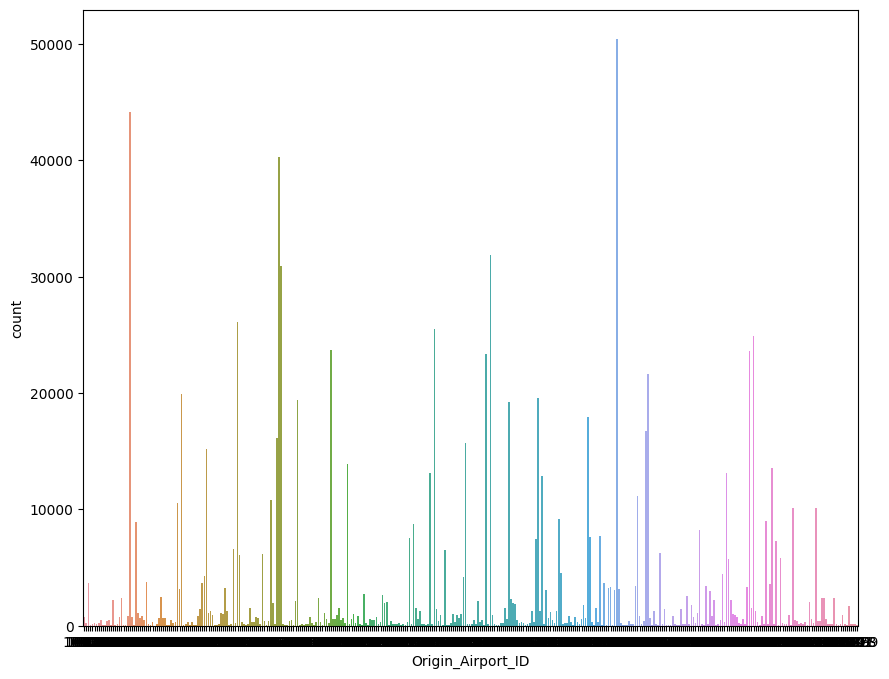

########## Origin_Airport ##########

256    50436
22     44140
94     40300
195    31825
95     30879
       ...  
9         14
147       13
98         9
13         8
34         6
Name: Origin_Airport, Length: 374, dtype: int64 



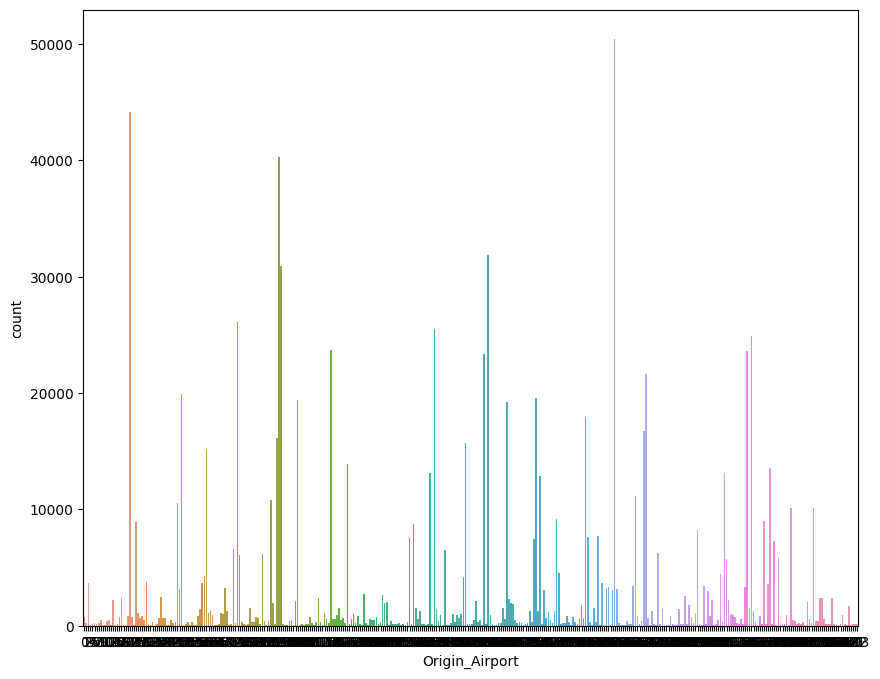

########## Destination_Airport ##########

ORD    50171
ATL    43626
DEN    39693
LAX    31936
DFW    30183
       ...  
WYS       12
BFM       11
DLG        8
GST        6
AKN        3
Name: Destination_Airport, Length: 374, dtype: int64 



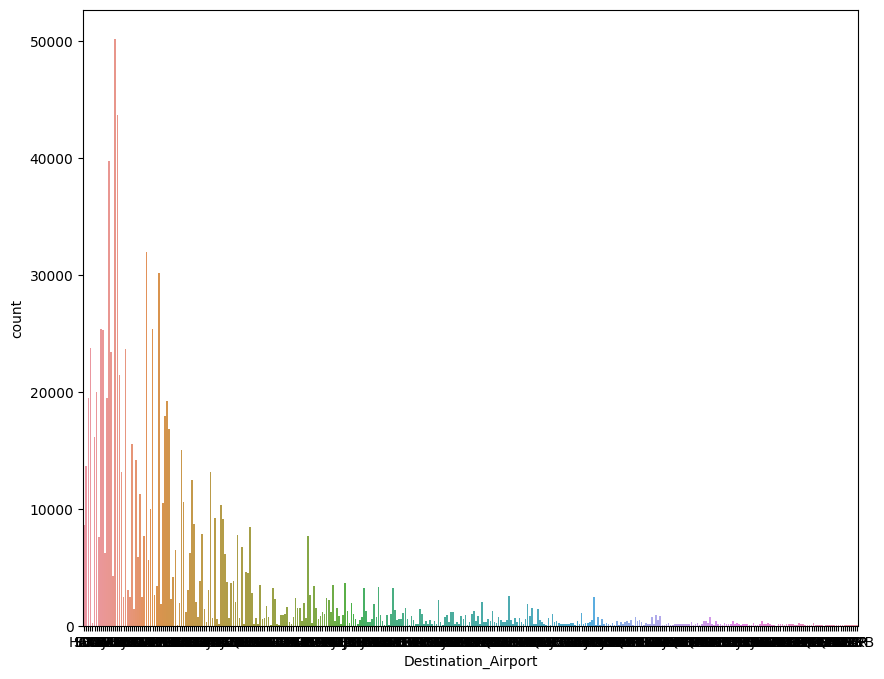

########## Airline ##########

Southwest Airlines Co.                       182113
Delta Air Lines Inc.                          89750
SkyWest Airlines Inc.                         86867
United Air Lines Inc.                         84070
American Airlines Inc.                        82755
JetBlue Airways                               41643
Republic Airlines                             33582
Alaska Airlines Inc.                          29141
Envoy Air                                     27455
Spirit Air Lines                              24998
Comair Inc.                                   24723
Mesa Airlines Inc.                            24679
Endeavor Air Inc.                             23172
ExpressJet Airlines Inc.                      20144
Frontier Airlines Inc.                        17415
Allegiant Air                                 13666
Air Wisconsin Airlines Corp                   13400
Horizon Air                                   13087
Hawaiian Airlines Inc.           

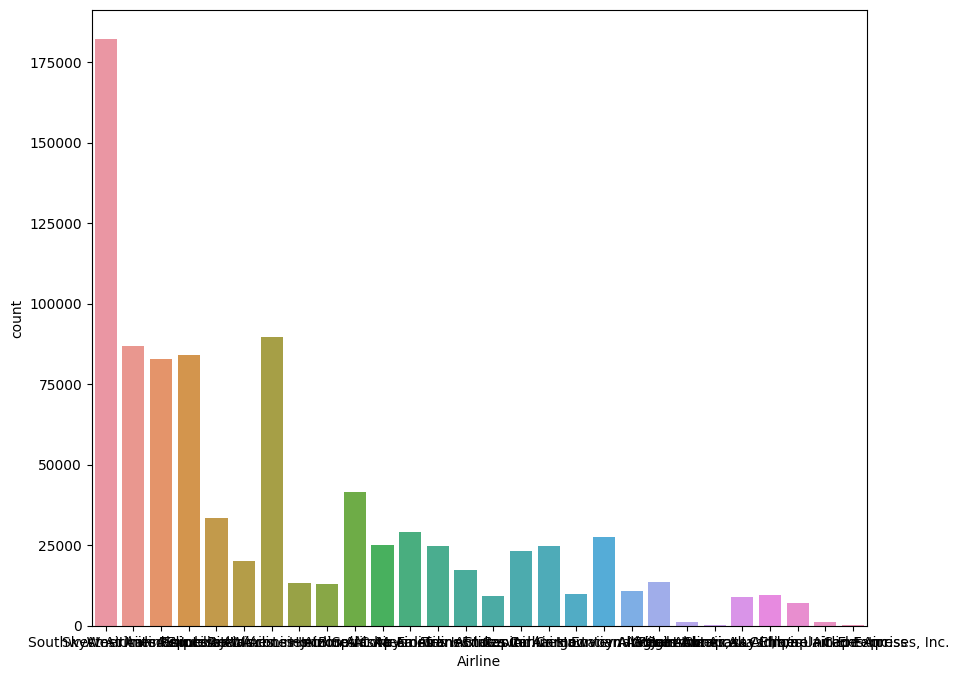

In [ ]:
print('########## Origin_Airport_ID  ##########\n')
print(train['Origin_Airport_ID'].value_counts(), '\n')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Origin_Airport_ID', data=train)
plt.show()

print('########## Origin_Airport ##########\n')
print(train['Origin_Airport'].value_counts(), '\n')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Origin_Airport', data=train)
plt.show()

print('########## Destination_Airport ##########\n')
print(train['Destination_Airport'].value_counts(), '\n')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Destination_Airport', data=train)
plt.show()

print('########## Airline ##########\n')
print(train['Airline'].value_counts(), '\n')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Airline', data=train)
plt.show()

<ipython-input-43-a44a1e0a726f>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), linewidths = 0.1, vmax = 1.0,


<Axes: title={'center': 'Correlation of Features'}>

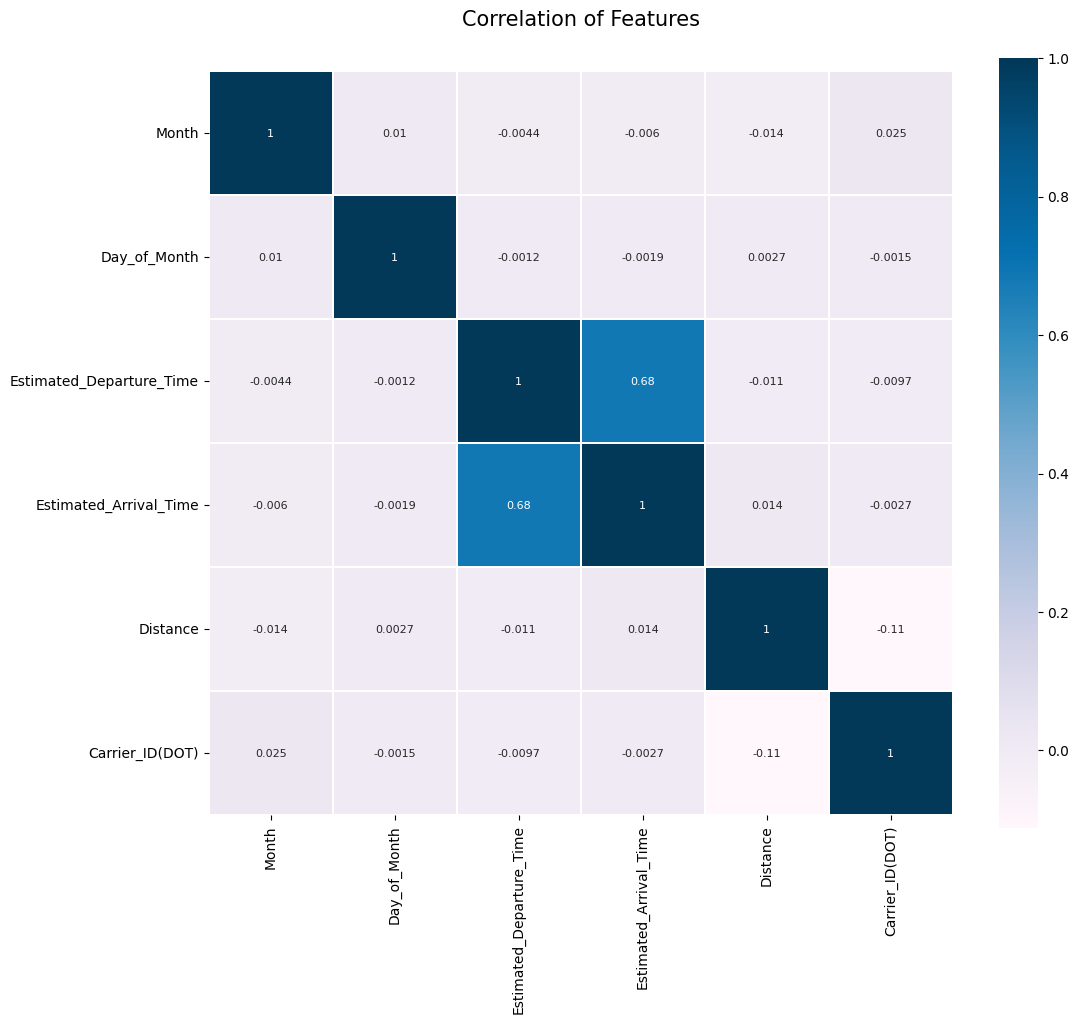

In [ ]:
# train['Estimated_Departure_Time'] = pd.to_datetime(train['Estimated_Departure_Time'])
# train['Estimated_Arrival_Time'] = pd.to_datetime(train['Estimated_Arrival_Time'])

# 상관관계 분석
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(train.corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 8})

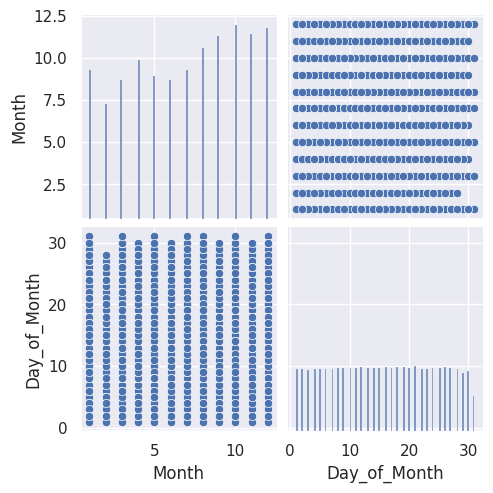

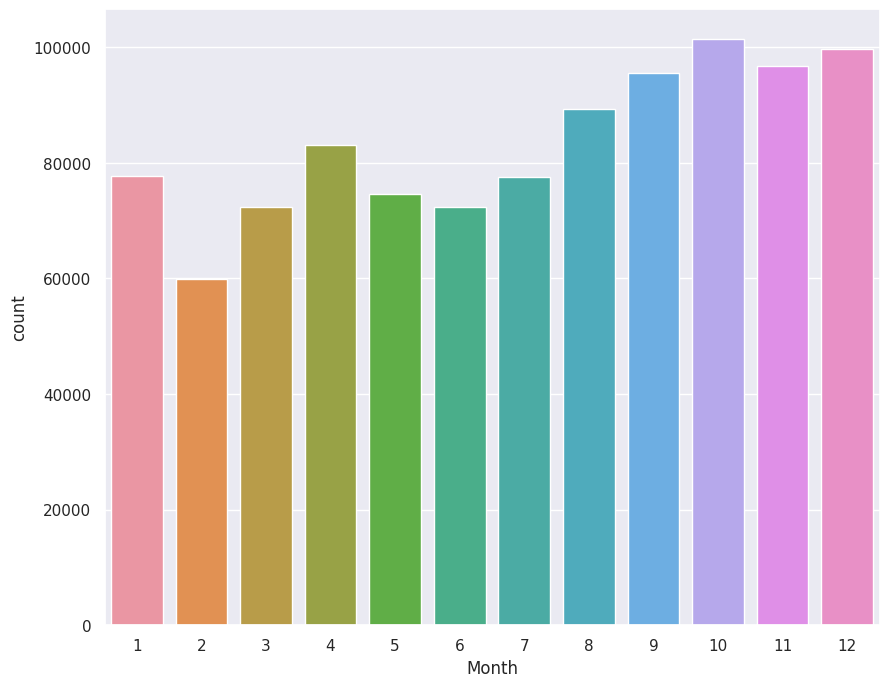

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Month', data=train)
plt.show()

In [ ]:
train.isnull().sum()

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time    109019
Estimated_Arrival_Time      109040
Cancelled                        0
Diverted                         0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                109015
Destination_Airport              0
Destination_Airport_ID           0
Destination_State           109079
Distance                         0
Airline                     108920
Carrier_Code(IATA)          108990
Carrier_ID(DOT)             108997
Tail_Number                      0
Delay                       744999
dtype: int64

# Data Pre-Processing

In [ ]:
train_label = train.loc[~train['Delay'].isnull()]
train_label.isnull().sum()

ID                              0
Month                           0
Day_of_Month                    0
Estimated_Departure_Time    27841
Estimated_Arrival_Time      27684
Origin_Airport                  0
Origin_Airport_ID               0
Origin_State                    0
Destination_Airport             0
Destination_Airport_ID          0
Destination_State               0
Distance                        0
Airline                     27540
Carrier_Code(IATA)          27888
Carrier_ID(DOT)             27770
Tail_Number                     0
Delay                           0
dtype: int64

In [ ]:
# 레이블(Delay)을 제외한 결측값이 존재하는 변수들을 학습 데이터의 최빈값으로 대체합니다
NaN_col = ['Airline','Estimated_Departure_Time', 'Estimated_Arrival_Time','Carrier_Code(IATA)','Carrier_ID(DOT)', 'Delay']

for col in NaN_col:
    mode = train[col].mode()[0]
    train[col] = train[col].fillna(mode)
    
    if col in test.columns:
        test[col] = test[col].fillna(mode)
print('Done.')

Done.


In [ ]:
train.isnull().sum()
# train['Delay'].head(100)

ID                               0
Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Origin_Airport                   0
Origin_Airport_ID                0
Origin_State                     0
Destination_Airport              0
Destination_Airport_ID           0
Destination_State                0
Distance                         0
Airline                          0
Carrier_Code(IATA)               0
Carrier_ID(DOT)                  0
Tail_Number                      0
Delay                       744999
dtype: int64

In [ ]:
# 질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])


print('Done.')

Done.


In [ ]:
# 질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train_label[i])
    train_label[i]=le.transform(train_label[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])


print('Done.')

<ipython-input-41-ff92e0a06af3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_label[i]=le.transform(train_label[i])
<ipython-input-41-ff92e0a06af3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_label[i]=le.transform(train_label[i])
<ipython-input-41-ff92e0a06af3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Done.


In [ ]:
d = ['Delay']

for i in d:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

In [ ]:
train.head(10)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,600.0,1900.0,252,34,159,42,419.0,23,10,19393.0,4319,1
1,TRAIN_000001,8,15,740.0,1024.0,256,11,331,45,1250.0,22,8,20304.0,310,1
2,TRAIN_000002,9,6,1610.0,1805.0,74,31,204,30,544.0,3,0,19805.0,140,1
3,TRAIN_000003,7,10,905.0,1735.0,195,4,119,28,2454.0,26,8,19393.0,3021,1
4,TRAIN_000004,1,11,900.0,1019.0,322,4,7,4,250.0,22,8,20304.0,556,1
5,TRAIN_000005,4,13,1545.0,1900.0,119,28,93,47,199.0,21,8,20452.0,3435,1
6,TRAIN_000006,1,20,1742.0,1903.0,119,28,47,19,200.0,26,8,19393.0,3495,1
7,TRAIN_000007,4,20,1815.0,1955.0,256,11,217,23,403.0,23,8,20304.0,173,1
8,TRAIN_000008,6,13,1420.0,1550.0,59,18,74,31,361.0,23,10,19393.0,4083,1
9,TRAIN_000009,6,6,650.0,838.0,207,3,169,42,374.0,13,8,20366.0,468,1


In [ ]:
#레이블이 없는 데이터들을 제거합니다
train = train.dropna()

In [ ]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train.loc[:, 'Delay_num'] = train['Delay'].apply(lambda x: to_number(x, column_number))
print('Done.')

Done.


In [ ]:
train_x = train.drop(columns=['ID', 'Delay'])
train_y = train['Delay']
test_x = test.drop(columns=['ID'])

# Classification Model Fit

In [ ]:
dtrain1 = xgb.DMatrix(data=train_x, label=y_resampled1)
dtest1 = xgb.DMatrix(data=X_test1, label=y_test1)

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_State,Destination_Airport,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay_num
0,4,15,600.0,1900.0,OKC,Oklahoma,HOU,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,0
1,8,15,740.0,1024.0,ORD,Illinois,SLC,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,0
2,9,6,1610.0,1805.0,CLT,North Carolina,LGA,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,0
3,7,10,905.0,1735.0,LAX,California,EWR,New Jersey,2454.0,United Air Lines Inc.,UA,19393.0,N595UA,0
4,1,11,900.0,1019.0,SFO,California,ACV,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,18,936.0,1243.0,ORD,Illinois,PHL,Pennsylvania,678.0,United Air Lines Inc.,UA,19977.0,N477UA,0
999996,5,30,920.0,1028.0,FAR,North Dakota,MSP,Minnesota,223.0,SkyWest Airlines Inc.,DL,19393.0,N439SW,0
999997,6,28,800.0,1340.0,OAK,California,HOU,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,0
999998,9,27,1613.0,1824.0,BNA,Tennessee,ATL,Georgia,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,0


In [ ]:
def xgb_evaluate(max_depth, gamma, colsample_bytree,min_child_weight,eta,subsample):
    params = {'eval_metric': 'auc',
              'objective':'binary:logistic',
              'min_child_weight': min_child_weight,
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': eta,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, train_x, num_boost_round=100, nfold=3, metrics = 'auc')    
    
    return cv_result['test-auc-mean'].iloc[-1]

In [ ]:
cat_features = ['Origin_State', 'Origin_Airport', 'Destination_Airport', 'Destination_State',
                'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

model = CatBoostClassifier(iterations=10,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=cat_features)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# gb = GradientBoostingClassifier(learning_rate=0.03, max_depth=7).fit(train_x, train_y)
# lgb = lgb.LGBMClassifier(learning_rate=0.03, max_depth=7).fit(train_x, train_y)
a = XGBClassifier(learning_rate=0.02, max_depth=8).fit(train_x, train_y)
# b = model.fit(train_x, train_y)

# Inference

In [ ]:
ppp = model.predict(test_x)

CatBoostError: ignored

In [ ]:
# y_pred = gb.predict_proba(test_x)
# y_pred2 = lgb.predict_proba(test_x)
y_pred3 = a.predict_proba(test_x)

# Submit

In [ ]:
# submission1 = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
# submission2 = pd.DataFrame(data=y_pred2, columns=sample_submission.columns, index=sample_submission.index)
submission3 = pd.DataFrame(data=y_pred3, columns=sample_submission.columns, index=sample_submission.index)

In [ ]:
# submission1.to_csv('/content/drive/MyDrive/dacon_data/baseline_submission_gb.csv', index=True)
# submission2.to_csv('/content/drive/MyDrive/dacon_data/baseline_submission_lgb.csv', index=True)
submission3.to_csv('/content/drive/MyDrive/dacon_data/baseline_submission_xgb.csv', index=True)